# PROYECTO 3 - Security Data Science
### Parte 1

In [1]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from art.estimators.classification import KerasClassifier
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import ReverseSigmoid

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\art\estimators\certification\__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [2]:
# Escribir aqui el path de la carpeta con imagenes. Usar doble \\ para el path
path_root = "D:\\UVG\\9noSemestre\\SecurityDataScience\\Proyecto3---Security-DS\\malimg_dataset\\malimg_paper_dataset_imgs\\"

In [3]:
from keras.preprocessing.image import ImageDataGenerator
# se ven cuandas clases de imagenes hay en la data total
batches = ImageDataGenerator().flow_from_directory(directory = path_root, target_size = (64, 64), batch_size = 10000)

Found 9339 images belonging to 25 classes.


In [4]:
# Usamos next() para recorrer todos los elementos y generar un batch de imagenes y label del data set
imgs, labels = next(batches)

In [5]:
# nuestras imagenes estan en RGB con formato 64x64 [width x length x depth].
imgs.shape

(9339, 64, 64, 3)

# Entrenamiento y prueba
Se divide la data en 70% train y 30% test 

In [6]:
X_train, X_test0, y_train, y_test0 = train_test_split(imgs / 255., labels, test_size = 0.45)

In [7]:
X_train.shape

(5136, 64, 64, 3)

# Modelo de Red Neural Convolutional

In [8]:
num_classes = 25 # se define el total de clases encontradas en las secciones anteriores

def malware_model():
    # funcion para crear el modelo secuencial que permitira analizar el malware segun las imagenes
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [9]:
Malware_model = malware_model() # se crea el modelo

In [10]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [11]:
y_train.shape

(5136, 25)

In [12]:
y_train_new = np.argmax(y_train, axis=1) # se extraen solo las clases
y_train_new

array([ 7,  3,  2, ..., 23,  2, 14], dtype=int64)

### Entrenamiento 

In [13]:
Malware_model.fit(X_train, y_train, validation_data=(X_test0, y_test0), epochs=10)

Epoch 1/10
161/161 [==============================] - 23s 137ms/step - loss: 1.8753 - accuracy: 0.4348 - val_loss: 0.9762 - val_accuracy: 0.6681
Epoch 2/10
161/161 [==============================] - 23s 141ms/step - loss: 0.8775 - accuracy: 0.7087 - val_loss: 0.5512 - val_accuracy: 0.7804
Epoch 3/10
161/161 [==============================] - 22s 137ms/step - loss: 0.5170 - accuracy: 0.8419 - val_loss: 0.2862 - val_accuracy: 0.9077
Epoch 4/10
161/161 [==============================] - 22s 140ms/step - loss: 0.3588 - accuracy: 0.8880 - val_loss: 0.2080 - val_accuracy: 0.9329
Epoch 5/10
161/161 [==============================] - 21s 129ms/step - loss: 0.2675 - accuracy: 0.9200 - val_loss: 0.2040 - val_accuracy: 0.9393
Epoch 6/10
161/161 [==============================] - 22s 137ms/step - loss: 0.2303 - accuracy: 0.9274 - val_loss: 0.1711 - val_accuracy: 0.9443
Epoch 7/10
161/161 [==============================] - 22s 139ms/step - loss: 0.2209 - accuracy: 0.9276 - val_loss: 0.1508 - val_ac

In [14]:
scores = Malware_model.evaluate(X_test0, y_test0)

132/132 [==============================] - 4s 30ms/step - loss: 0.1427 - accuracy: 0.9576


In [15]:
print('Accuracy final CNN: ', scores[1])
# Fue bastante alto el accuracy obtenido

Accuracy final CNN:  0.957649290561676


In [16]:
# se guarda el modelo 
Malware_model.save('malware-listo-model.h5')

In [17]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

In [18]:
# Recrea exactamente el mismo modelo solo cargandolo desde el archivo
malware_model = keras.models.load_model('malware-listo-model.h5')

In [19]:
classifier_original = KerasClassifier(malware_model, clip_values=(0, 1), use_logits=False) # se convierte en un clasificador de Keras

### Modelo no protegido

In [20]:
num_epochs = 10 # se guarda el numero de epocas con las que el modelo se entreno y cuanta data extraer
len_steal = 5000 
# Stealing from the unprotected classifier.
attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

In [21]:
def malware_steal_model():
    # se crea un nuevo modelo para la data robada
    Malware_model = Sequential(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))
   
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [22]:
results = []
for len_steal in [250, 500, 1000, 2000, 3000, 4000]:
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = malware_steal_model()
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 250 samples
Epoch 1/10
250/250 [==============================] - 1s 4ms/sample - loss: 3.0328 - accuracy: 0.2120
Epoch 2/10
250/250 [==============================] - 1s 2ms/sample - loss: 2.7882 - accuracy: 0.3440
Epoch 3/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.6907 - accuracy: 0.3280
Epoch 4/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.5611 - accuracy: 0.3080
Epoch 5/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.4791 - accuracy: 0.3440
Epoch 6/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.3873 - accuracy: 0.3080
Epoch 7/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.2482 - accuracy: 0.3400
Epoch 8/10
250/250 [==============================] - 1s 2ms/sample - loss: 2.1859 - accuracy: 0.4200
Epoch 9/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.0741 - accuracy: 0.4680
Epoch 10/10
250/250 [==============================] - 1s 3ms

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN : 0.43561852
Train on 250 samples
Epoch 1/10
250/250 [==============================] - 1s 4ms/sample - loss: 3.0730 - accuracy: 0.0920
Epoch 2/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.8327 - accuracy: 0.2320
Epoch 3/10
250/250 [==============================] - 1s 2ms/sample - loss: 2.6312 - accuracy: 0.2560
Epoch 4/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.6460 - accuracy: 0.2280
Epoch 5/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.5598 - accuracy: 0.2960
Epoch 6/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.4195 - accuracy: 0.3120
Epoch 7/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.3978 - accuracy: 0.3040
Epoch 8/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.1928 - accuracy: 0.3600
Epoch 9/10
250/250 [==============================] - 1s 3ms/sample - loss: 2.1189 - accuracy: 0.3880
Epoch 10/10
250/250 [==

3000/3000 [==============================] - 18s 6ms/sample - loss: 1.4028 - accuracy: 0.5633
Epoch 4/10
3000/3000 [==============================] - 17s 6ms/sample - loss: 1.1073 - accuracy: 0.6340
Epoch 5/10
3000/3000 [==============================] - 18s 6ms/sample - loss: 0.8866 - accuracy: 0.7070
Epoch 6/10
3000/3000 [==============================] - 18s 6ms/sample - loss: 0.7454 - accuracy: 0.7790
Epoch 7/10
3000/3000 [==============================] - 18s 6ms/sample - loss: 0.6014 - accuracy: 0.8143
Epoch 8/10
3000/3000 [==============================] - 18s 6ms/sample - loss: 0.5211 - accuracy: 0.8580
Epoch 9/10
3000/3000 [==============================] - 18s 6ms/sample - loss: 0.4602 - accuracy: 0.8727
Epoch 10/10
3000/3000 [==============================] - 20s 7ms/sample - loss: 0.4087 - accuracy: 0.8903
Probabilistic CopycatCNN : 0.89193684
Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 20s 7ms/sample - loss: 2.4750 - accuracy: 0.3317
Epoch

## Grafica de la curva ROC
del modelo no protegido

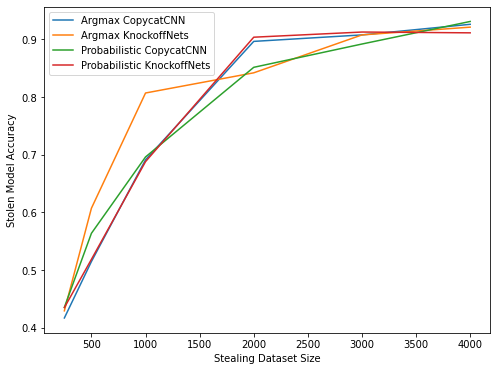

In [23]:
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

Se observa como en entre los ataques probabilisticos, el de KnockoffNets tienen mayor accuracy. Y de forma contraria en los no probabilisticos, CopycatCNN tiene el accuracy mas alto.

### Modelo protegido

In [24]:
# Se prepara la capa para DEFENSA
postprocessor = ReverseSigmoid(beta = 1.0, gamma = 0.2)
classifier_protected = KerasClassifier(malware_model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# En la siguiente parte se usa `FunctionallyEquivalentExtraction` pero toma demasiado tiempo
model_flat = Sequential([InputLayer([64, 64, 3]), Reshape([64, 64, 3]), malware_model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [25]:
# Se roba data del clasificador protegido con la misma cantidad de epocas que los anteriores y cuanta data extraer
num_epochs = 10
len_steal = 5000
attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
}

In [26]:
results_protected = []
for len_steal in [250, 500, 1000, 2000, 3000, 4000]:
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = malware_steal_model()
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            # Se modifica el shape de la data 
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 250 samples
Epoch 1/10
250/250 [==============================] - 2s 9ms/sample - loss: 3.2939 - accuracy: 0.0200
Epoch 2/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2230 - accuracy: 0.0200
Epoch 3/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2194 - accuracy: 0.0160
Epoch 4/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2189 - accuracy: 0.0320
Epoch 5/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2188 - accuracy: 0.0600
Epoch 6/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2188 - accuracy: 0.0600
Epoch 7/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2187 - accuracy: 0.0800
Epoch 8/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2187 - accuracy: 0.0640
Epoch 9/10
250/250 [==============================] - 2s 7ms/sample - loss: 3.2186 - accuracy: 0.0760
Epoch 10/10
250/250 [==============================] - 2s 7ms

C:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN (vs. Protected) : 0.08778143
Train on 250 samples
Epoch 1/10
250/250 [==============================] - 2s 9ms/sample - loss: 2.9907 - accuracy: 0.2040
Epoch 2/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.6483 - accuracy: 0.2560
Epoch 3/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.5176 - accuracy: 0.2840
Epoch 4/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.4179 - accuracy: 0.3680
Epoch 5/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.3662 - accuracy: 0.3480
Epoch 6/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.3241 - accuracy: 0.3360
Epoch 7/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.2180 - accuracy: 0.3920
Epoch 8/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.1387 - accuracy: 0.3800
Epoch 9/10
250/250 [==============================] - 2s 7ms/sample - loss: 2.0338 - accuracy: 0.4080
Epoch 1

Argmax KnockoffNets (vs. Protected) : 0.8955969
Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 42s 14ms/sample - loss: 3.2216 - accuracy: 0.1633
Epoch 2/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2178 - accuracy: 0.2200
Epoch 3/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2175 - accuracy: 0.2983
Epoch 4/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2174 - accuracy: 0.3747
Epoch 5/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2173 - accuracy: 0.3920
Epoch 6/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2171 - accuracy: 0.4603
Epoch 7/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.2170 - accuracy: 0.4797
Epoch 8/10
3000/3000 [==============================] - 42s 14ms/sample - loss: 3.2168 - accuracy: 0.5310
Epoch 9/10
3000/3000 [==============================] - 41s 14ms/sample - loss: 3.

## Grafica de la curva ROC
Del modelo protegido

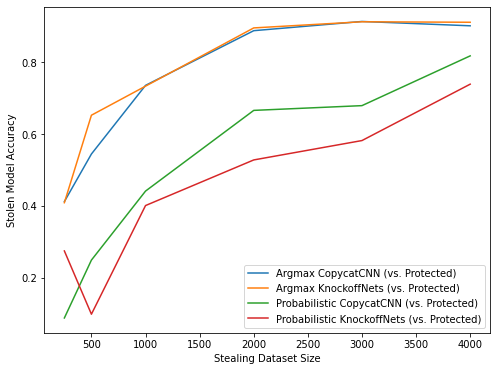

In [27]:
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

## Grafica de la curva ROC
de los modelos segun el tipo de ataque utilizado (CopycatCNN o KnockoffNets)

In [28]:
df_combined = pd.concat([df, df_protected]) # se agrupa la data robada de los modelos creados con diferentes metodos de ataque
groupby = df_combined.groupby("Method Name")

C:\Users\diana\AppData\Local\Temp\ipykernel_10128\3763360729.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\diana\AppData\Local\Temp\ipykernel_10128\3763360729.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


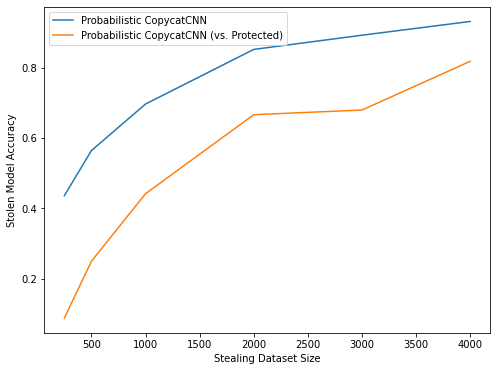

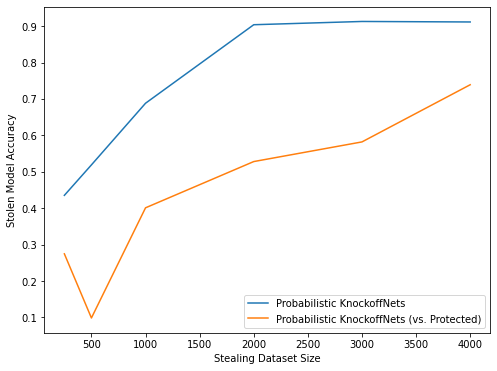

In [29]:
names = ["CopycatCNN", "KnockoffNets"] # metodos de ataques usados
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1, 2,ax = ax, label = "Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()

Se puede ver como el accuracy en ambos tipos de ataque fue mayor en el modelo sin proteccion, tal como era de esperarse aunque la diferencia en ambos casos es unicamente del 0.2